C:\Users\dowdd\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Analyzing stocks from watchlist...


[*********************100%%**********************]  1 of 1 completed


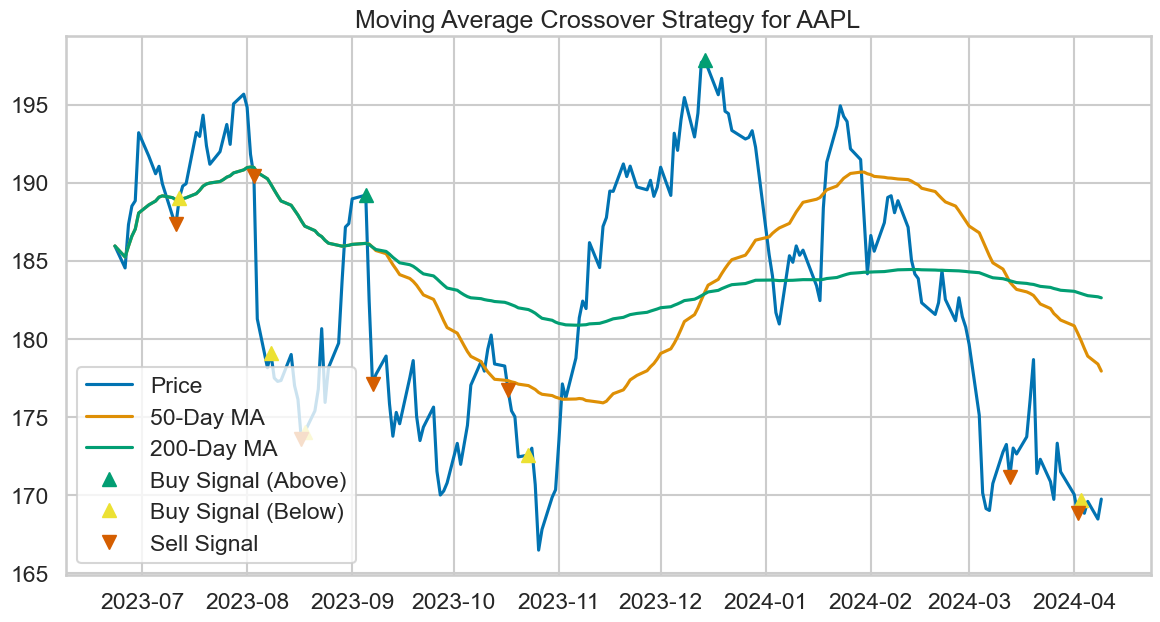

[*********************100%%**********************]  1 of 1 completed

Current period for AAPL is neither a buy nor sell period.


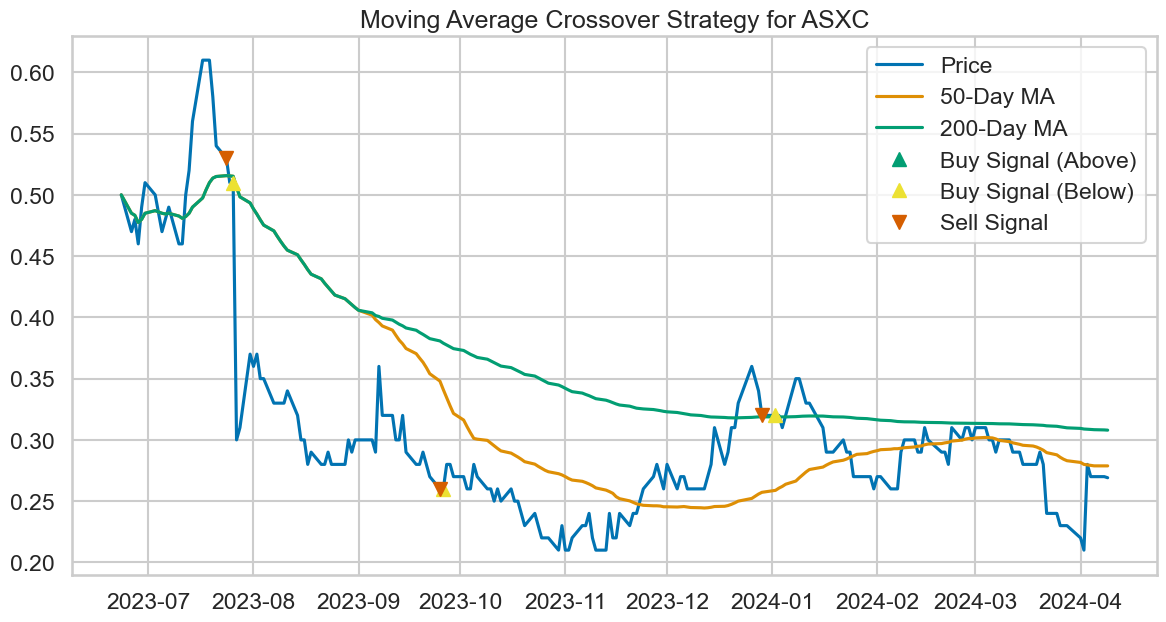

[*********************100%%**********************]  1 of 1 completed

Current period for ASXC is neither a buy nor sell period.
Analyzing stocks from positions...


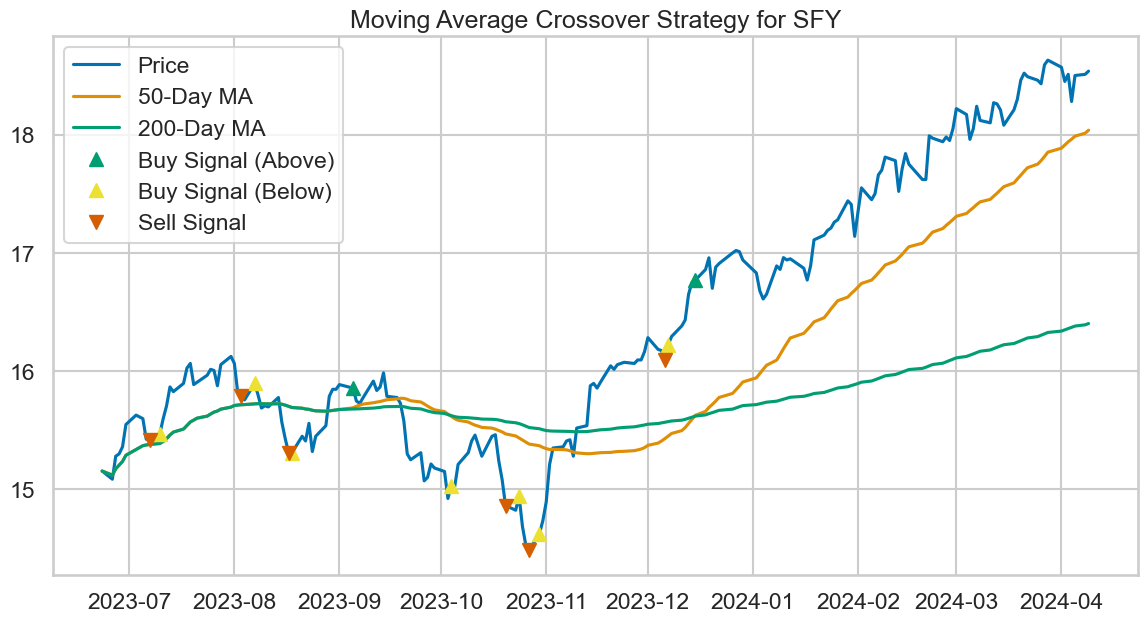

[*********************100%%**********************]  1 of 1 completed

Current period for SFY is a buy period.


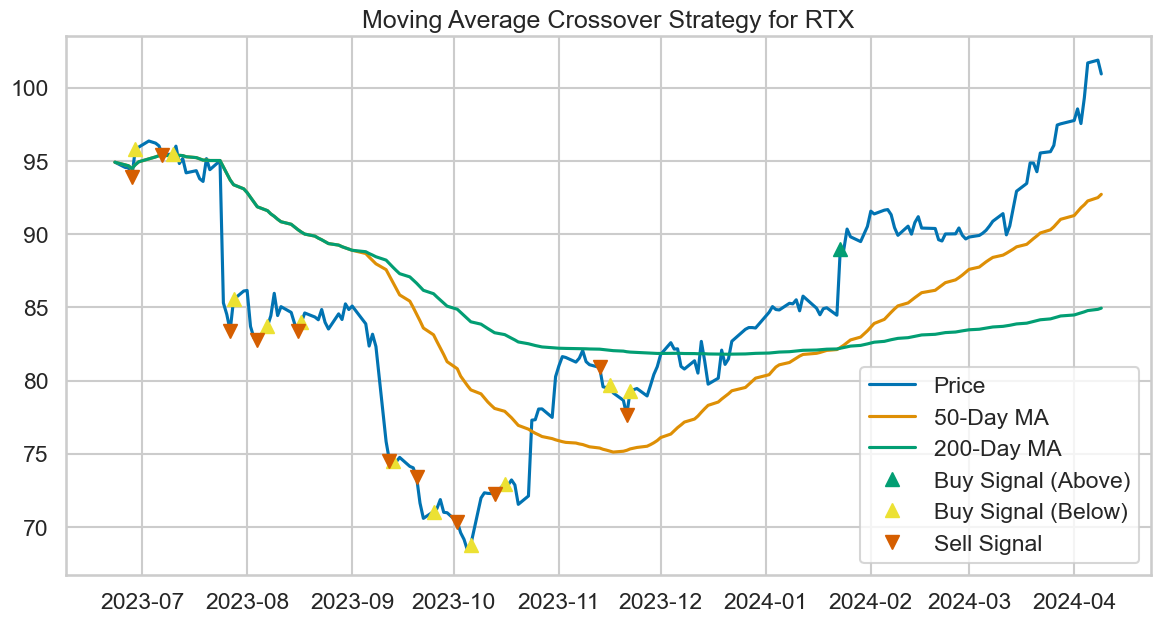

Current period for RTX is a buy period.

Stock Analysis Menu:
1. Add stock to watchlist
2. Add stock to positions
3. Buy stock (move from watchlist to positions)
4. Sell stock (move from positions to watchlist)
5. Analyze stock
6. Exit


In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

sns.set_theme(context='talk', style='whitegrid', palette = 'colorblind', color_codes=True, rc={'figure.figsize': [12,8]})

# Set the path to the 'stocks' folder
stocks_folder = 'stocks'

# Function to perform the analysis and plot the strategy for a given stock
def analyze_stock(stock, period):
    data = yf.download(stock, period=period)

    # Calculate short-term and long-term moving averages
    short_window = 50
    long_window = 200

    data['Short_MA'] = data['Adj Close'].rolling(window=short_window, min_periods=1).mean()
    data['Long_MA'] = data['Adj Close'].rolling(window=long_window, min_periods=1).mean()

    # Generate buy and sell signals
    data['Signal'] = 0
    data['Signal'][short_window:] = np.where(data['Short_MA'][short_window:] > data['Long_MA'][short_window:], 1, 0)

    # Generate sell signal if the change is negative for three consecutive days
    data['Change'] = data['Adj Close'].pct_change()
    data['Sell_Signal'] = np.where((data['Change'] < 0) & (data['Change'].shift(1) < 0) & (data['Change'].shift(2) < 0), -1, 0)

    # Combine buy and sell signals
    data['Signal'] = np.where(data['Sell_Signal'] == -1, -1, data['Signal'])

    # Ensure buy and sell signals alternate
    data['Signal'] = data['Signal'].where(data['Signal'].diff().ne(0)).ffill().astype(int)

    data['Position'] = data['Signal'].diff()

    # Plot the strategy
    plt.figure(figsize=(14, 7))
    plt.plot(data['Adj Close'], label='Price')
    plt.plot(data['Short_MA'], label='50-Day MA')
    plt.plot(data['Long_MA'], label='200-Day MA')
    
    # Plot buy signals in green or yellow based on the condition
    plt.plot(data[(data['Position'] == 1) & (data['Short_MA'] > data['Long_MA'])].index,
             data['Adj Close'][(data['Position'] == 1) & (data['Short_MA'] > data['Long_MA'])],
             '^', markersize=10, color='g', lw=0, label='Buy Signal (Above)')
    plt.plot(data[(data['Position'] == 1) & (data['Short_MA'] <= data['Long_MA'])].index,
             data['Adj Close'][(data['Position'] == 1) & (data['Short_MA'] <= data['Long_MA'])],
             '^', markersize=10, color='y', lw=0, label='Buy Signal (Below)')
    
    plt.plot(data[data['Position'] == -1].index, data['Adj Close'][data['Position'] == -1],
             'v', markersize=10, color='r', lw=0, label='Sell Signal')
    plt.title('Moving Average Crossover Strategy for ' + stock)
    plt.legend()
    plt.show()

    # Print whether the current period is a buy or sell period
    if data['Signal'][-1] == 1:
        print(f"Current period for {stock} is a buy period.")
    elif data['Signal'][-1] == -1:
        print(f"Current period for {stock} is a sell period.")
    else:
        print(f"Current period for {stock} is neither a buy nor sell period.")

# Function to add a stock to the watchlist or positions
def add_stock(stock, list_type):
    if list_type == 'watchlist':
        file_path = os.path.join(stocks_folder, 'watchlist.csv')
    elif list_type == 'positions':
        file_path = os.path.join(stocks_folder, 'positions.csv')
    else:
        print("Invalid list type. Choose 'watchlist' or 'positions'.")
        return

    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()
            tickers = [line.strip().split(',')[0] for line in lines]

        if stock not in tickers:
            with open(file_path, 'a') as file:
                file.write(f"\n{stock}")
            print(f"{stock} added to {list_type}.")
        else:
            print(f"{stock} already exists in {list_type}.")
    except FileNotFoundError:
        with open(file_path, 'w') as file:
            file.write("Ticker")
            file.write(f"\n{stock}")
        print(f"{stock} added to {list_type}.")

# Function to buy a stock (move from watchlist to positions)
def buy_stock(stock):
    watchlist_file = os.path.join(stocks_folder, 'watchlist.csv')
    positions_file = os.path.join(stocks_folder, 'positions.csv')

    watchlist_df = pd.read_csv(watchlist_file)
    positions_df = pd.read_csv(positions_file)

    if stock in watchlist_df['Ticker'].values:
        stock_data = watchlist_df[watchlist_df['Ticker'] == stock]
        positions_df = positions_df.append(stock_data, ignore_index=True)
        watchlist_df = watchlist_df[watchlist_df['Ticker'] != stock]

        positions_df.to_csv(positions_file, index=False)
        watchlist_df.to_csv(watchlist_file, index=False)

        print(f"{stock} bought and moved from watchlist to positions.")
    else:
        print(f"{stock} not found in the watchlist.")

# Function to sell a stock (move from positions to watchlist)
def sell_stock(stock):
    watchlist_file = os.path.join(stocks_folder, 'watchlist.csv')
    positions_file = os.path.join(stocks_folder, 'positions.csv')

    watchlist_df = pd.read_csv(watchlist_file)
    positions_df = pd.read_csv(positions_file)

    if stock in positions_df['Ticker'].values:
        stock_data = positions_df[positions_df['Ticker'] == stock]
        watchlist_df = watchlist_df.append(stock_data, ignore_index=True)
        positions_df = positions_df[positions_df['Ticker'] != stock]

        positions_df.to_csv(positions_file, index=False)
        watchlist_df.to_csv(watchlist_file, index=False)

        print(f"{stock} sold and moved from positions to watchlist.")
    else:
        print(f"{stock} not found in the positions.")

def analyze_stocks_from_file(file_path, period):
    df = pd.read_csv(file_path)
    tickers = df['Ticker'].tolist()
    for ticker in tickers:
        analyze_stock(ticker, period)

# Analyze and plot stocks from watchlist and positions on boot
period = '200d'
watchlist_file = os.path.join(stocks_folder, 'watchlist.csv')
positions_file = os.path.join(stocks_folder, 'positions.csv')

print("Analyzing stocks from watchlist...")
analyze_stocks_from_file(watchlist_file, period)

print("Analyzing stocks from positions...")
analyze_stocks_from_file(positions_file, period)

# User interface
while True:
    print("\nStock Analysis Menu:")
    print("1. Add stock to watchlist")
    print("2. Add stock to positions")
    print("3. Buy stock (move from watchlist to positions)")
    print("4. Sell stock (move from positions to watchlist)")
    print("5. Analyze stock")
    print("6. Exit")

    choice = input("Enter your choice (1-6): ")

    if choice == '1':
        stock = input("Enter the stock ticker to add to watchlist: ")
        add_stock(stock, 'watchlist')
    elif choice == '2':
        stock = input("Enter the stock ticker to add to positions: ")
        add_stock(stock, 'positions')
    elif choice == '3':
        stock = input("Enter the stock ticker to buy: ")
        buy_stock(stock)
    elif choice == '4':
        stock = input("Enter the stock ticker to sell: ")
        sell_stock(stock)
    elif choice == '5':
        stock = input("Enter the stock ticker to analyze: ")
        period = '200d'
        analyze_stock(stock, period)
    elif choice == '6':
        print("Exiting the program.")
        break
    else:
        print("Invalid choice. Please try again.")
        